In [ ]:
import numpy as np
%matplotlib notebook
import scipy
from scipy import fftpack
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG, Audio
import pywt

plt.rcParams['image.cmap'] = 'gray'

def color2bw(img):
    return np.dot(img, [0.299, 0.587, 0.114]) 

import skimage

# Descomposición multiresolución para imágenes

Se refiere a separar una imagen en componentes de cada vez menos resolución

Se puede usar un esquema de tipo piramidal

Se calcula una versión de baja resolución de la imagen, se resta a la original y luego se "achica"

Se guarda la versión más pequeña y los residuos (restas de imagenes)

Ventajas: 
- Podemos reconstruir la imagen aumentando la resolución y sumando los residuos
- Los residuos son fáciles de guardar: Distribución muy predecible: Entropía baja

In [ ]:
data = skimage.img_as_float(skimage.data.camera()[::2, ::2])

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for ax_ in ax.ravel():
    ax_.axis('off')
ax[0, 0].imshow(data) 
smooth = skimage.filters.gaussian(data, sigma=1)
ax[1, 0].imshow(smooth)
delta = data - smooth
ax[0, 1].imshow(delta)
ax[1, 1].imshow(smooth[::2, ::2]);

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(data.ravel(), bins=100, density=True);
ax[1].hist(delta.ravel(), bins=100, density=True);
ax[0].set_title('Original')
ax[1].set_title('Residuo');

Cada vez que submuestreamos repetimos el proceso 

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for ax_, im1, im2 in zip(ax, 
                   skimage.transform.pyramids.pyramid_gaussian(data, max_layer=3, downscale=2, multichannel=False),
                   skimage.transform.pyramids.pyramid_laplacian(data, max_layer=3, downscale=2)):
    ax_[0].imshow(im1)  
    ax_[1].imshow(im2)
    ax_[0].axis('off'); ax_[1].axis('off')

# Imágenes y frecuencia

Recordemos que 
- Las tendencias están en las frecuencias bajas
- Los detalles están en las frecuencias altas

Podemos hacer una descomposición multiresolución en frecuencia

Una herramienta ampliamente usada para esto son los **wavelets**

Usaremos una librería de Python llamado [pywavelets](https://pywavelets.readthedocs.io/en/latest/ref/index.html)

# Wavelets

Originalmente se diseñaron para analizar señales unidimensionales

Se definen a partir de dos funciones de ancho de banda limitado 
- Función wavelet $\psi(t)$ que modela detalles (wavelet madre)
- Función de escalamiento $\phi(t)$ que modela tendencias (wavelet padre)

Luego se generan versiones trasladadas y escaladas con cada uno: **wavelet hijos/hijas**

$$
\psi_{s,\tau}(t)  = \frac{1}{\sqrt{s}} \psi \left ( \frac{t-\tau}{s} \right)
$$

Notemos que el wavelet tiene localización en el tiempo (parámetro $\tau$) y escala de resolución (parámetro $s$) 

Podemos extraer comportamientos de una señal convolucionando con wavelets de distintas posiciones y escalas

El proceso para encontrar los wavelets más importantes en una señal se realiza con la **Transformada Wavelet** 

$$
W_\psi(\tau, s) = \int f(t) \psi_{s,\tau} (t)\,dt
$$

Los wavelet son ampliamente usados para análisis tiempo-frecuencia 

In [ ]:
import pywt

# Creando un objeto wavelet
fig, ax = plt.subplots(figsize=(6, 4))

w = pywt.Wavelet('bior4.4') # Versión 1D del wavelet usado en el estándar JPEG 2000
phi, psi, phi_r, psi_r, x = w.wavefun(5)
ax.plot(x, phi, label='padre')
ax.plot(x, psi, label='madre')
plt.legend();

Wavelets discretos implementados en pywt

In [ ]:
print(pywt.families(short=True))
print(pywt.wavelist(kind='discrete', family='bior'))

In [ ]:
t, dt = np.linspace(0, 0.5, num=10000, retstep=True);
s = scipy.signal.chirp(t, f0=5000, f1=3000, t1=t[-1], method='quadratic')
Audio(s, rate=1.0/dt)

## Transformada wavelet continua de un chirp

In [ ]:
coef, freqs = pywt.cwt(s, np.arange(1, 100, step=0.1), 'morl', sampling_period=dt)
fig, ax = plt.subplots(figsize=(6, 4))
X, Y = np.meshgrid(t, freqs)
ax.contourf(X, Y, np.abs(coef), cmap=plt.cm.viridis);

# Transformada Wavelet discreta

Podemos representar un wavelet en tiempo discreto $n$, traslaciones discretas $k$ y escalas discretos $j$

$$
\psi_{j, k} (n) = 2^{j/2} \psi(2^j n - k)
$$

una señal discreta $f(n)$ puede descomponerse como

$$
f(n) = \frac{1}{\sqrt{M}} \sum_k W_\varphi (j_0, k) \varphi_{j_0, k}(n) +  \frac{1}{\sqrt{M}} \sum_k \sum_{j=j_0}^\infty W_\varphi(j, k) \psi_{j, k}(n)
$$

Donde los $W_\psi (j_0, k)$ es la transformada wavelet padre y $W_\phi (j, k)$ es la transformada wavelet padre

Los primeros coeficientes guardan tendencias, los segundos guardan detalles

- La transformada wavelet discreta 1D retorna estos dos conjuntos de coeficientes
- La transformada wavelet discreta 2D retorna cuatro conjuntos: tendencia, detalles horizontal, verticales y diagonales

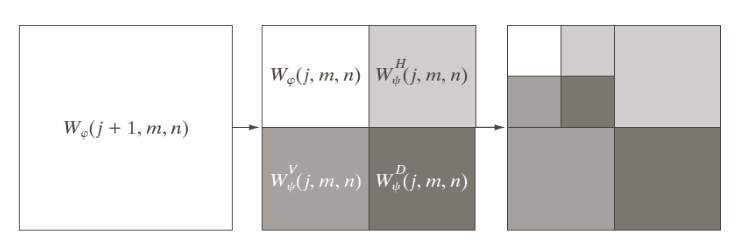

Cómo ya vimos las "imágenes" de detalles son predecibles, es decir que se pueden comprimir facilmente!

In [ ]:
LL, (LH, HL, HH) = pywt.dwt2(data, wavelet='db1')

fig, ax = plt.subplots(2, 2, figsize=(9, 8))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0, wspace=0)
for ax_ in ax.ravel():
    ax_.axis('off')
ax[0, 0].imshow(LL); ax[0, 0].set_title("LL")
ax[0, 1].imshow(LH); ax[0, 1].set_title("LH")
ax[1, 0].imshow(HL); ax[1, 0].set_title("HL")
ax[1, 1].imshow(HH); ax[1, 1].set_title("HH");

LL, (LH, HL, HH) = pywt.dwt2(LL, wavelet='db1')
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0, wspace=0)
for ax_ in ax.ravel():
    ax_.axis('off')
ax[0, 0].imshow(LL); ax[0, 0].set_title("LL")
ax[0, 1].imshow(LH); ax[0, 1].set_title("LH")
ax[1, 0].imshow(HL); ax[1, 0].set_title("HL")
ax[1, 1].imshow(HH); ax[1, 1].set_title("HH");

LL, (LH, HL, HH) = pywt.dwt2(LL, wavelet='db1')
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0, wspace=0)
for ax_ in ax.ravel():
    ax_.axis('off')
ax[0, 0].imshow(LL); ax[0, 0].set_title("LL")
ax[0, 1].imshow(LH); ax[0, 1].set_title("LH")
ax[1, 0].imshow(HL); ax[1, 0].set_title("HL")
ax[1, 1].imshow(HH); ax[1, 1].set_title("HH");

In [ ]:
plt.figure()
plt.hist(data.ravel(), bins=50, density=True, alpha=0.5)
plt.hist(HH.ravel(), bins=50, density=True, alpha=0.5);

# Recursos de interés
- [Compresión con wavelets](http://www.stat.columbia.edu/~jakulin/Wavelets/index.html)
- [Wavelet denoising](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise_wavelet.html)
- [Introducción a wavelets con pywt](www.acme.byu.edu/wp-content/uploads/2017/08/Wavelets.pdf)
- [Wavelets en machine learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)